# Importações

In [1]:
# Importações
# Manipulação e análise de dados
import pandas as pd  # Trabalha com DataFrames, que são tabelas de dados
import numpy as np  # Trabalha com arrays e funções matemáticas

# Visualização de dados
import matplotlib.pyplot as plt  # Cria gráficos estáticos e personalizados
import seaborn as sns  # Simplifica a criação de gráficos estatísticos
import plotly.express as px  # Cria gráficos interativos de maneira fácil

# Pré-processamento de dados
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder  # Codifica variáveis categóricas e padroniza os dados numéricos

# Modelos de classificação
from sklearn.tree import DecisionTreeClassifier  # Implementa árvores de decisão para classificação
from sklearn.naive_bayes import GaussianNB  # Modelo Naive Bayes, uma abordagem probabilística para classificação
from sklearn.neighbors import KNeighborsClassifier  # Implementa o classificador K-vizinhos mais próximos

# Divisão e avaliação de modelos
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV  # Divide os dados, faz validação cruzada e ajusta hiperparâmetros

# Métricas de desempenho
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, confusion_matrix  # Gera um relatório de métricas de classificação (precisão, recall, etc.) e calcula a matriz de confusão

# Transformações e seleção de colunas
from sklearn.compose import ColumnTransformer, make_column_selector  # Aplica transformações em colunas específicas do dataset

# Redução de dimensionalidade
from sklearn.decomposition import PCA  # Reduz a dimensionalidade dos dados preservando variância

# Modelos ensemble (votação e bagging)
from sklearn.ensemble import VotingClassifier, BaggingClassifier  # Combina vários classificadores para melhorar o desempenho

# Tratamento de warnings
from sklearn.exceptions import FitFailedWarning  # Captura e trata erros de ajuste de modelos

# Balanceamento de dados desbalanceados
from imblearn.over_sampling import SMOTE  # Realiza oversampling de classes minoritárias usando SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  # Cria pipelines que suportam o uso de métodos do imbalanced-learn

# Salvamento de modelos
from joblib import dump  # Salva modelos treinados para reutilização

# Supressão de warnings
import warnings  # Gerencia avisos indesejados

In [2]:
warnings.filterwarnings('ignore', category=FitFailedWarning)

# Base

#### Realizando a leitura da base

In [3]:
dataset = pd.read_excel('./dataset_hestia.xlsx')

dataset.head(2)

,Usaria o App,Tipo de Instituição,Idade,Renda Mensal,Possui DNE,Mudança de Residência,Faculdade Possui Alojamento,Frequência de Uso de Apps de Moradia,Confiança em Avaliações de Outros Usuários
0,Não,Pública,37,Não possuo renda,Não,Não,Não,Baixa,Baixa
1,Sim,Privada,44,R$12.001 +,Sim,Não,Sim,Baixa,Média


Dataset contém 18000 linhas e 9 colunas

Estatísticas descritivas para variáveis numéricas (Idade):


,Idade
count,18000.000000
mean,31.425500
std,8.041644
min,18.000000
25%,24.000000
50%,31.000000
75%,38.000000
max,45.000000



Estatísticas descritivas para variáveis categóricas:


,Usaria o App,Tipo de Instituição,Renda Mensal,Possui DNE,Mudança de Residência,Faculdade Possui Alojamento,Frequência de Uso de Apps de Moradia,Confiança em Avaliações de Outros Usuários
count,18000,18000,18000,18000,18000,18000,18000,18000
unique,2,2,6,2,2,2,3,3
top,Sim,Pública,Não possuo renda,Sim,Não,Sim,Baixa,Média
freq,12591,12611,3953,11007,9479,9588,15486,9000


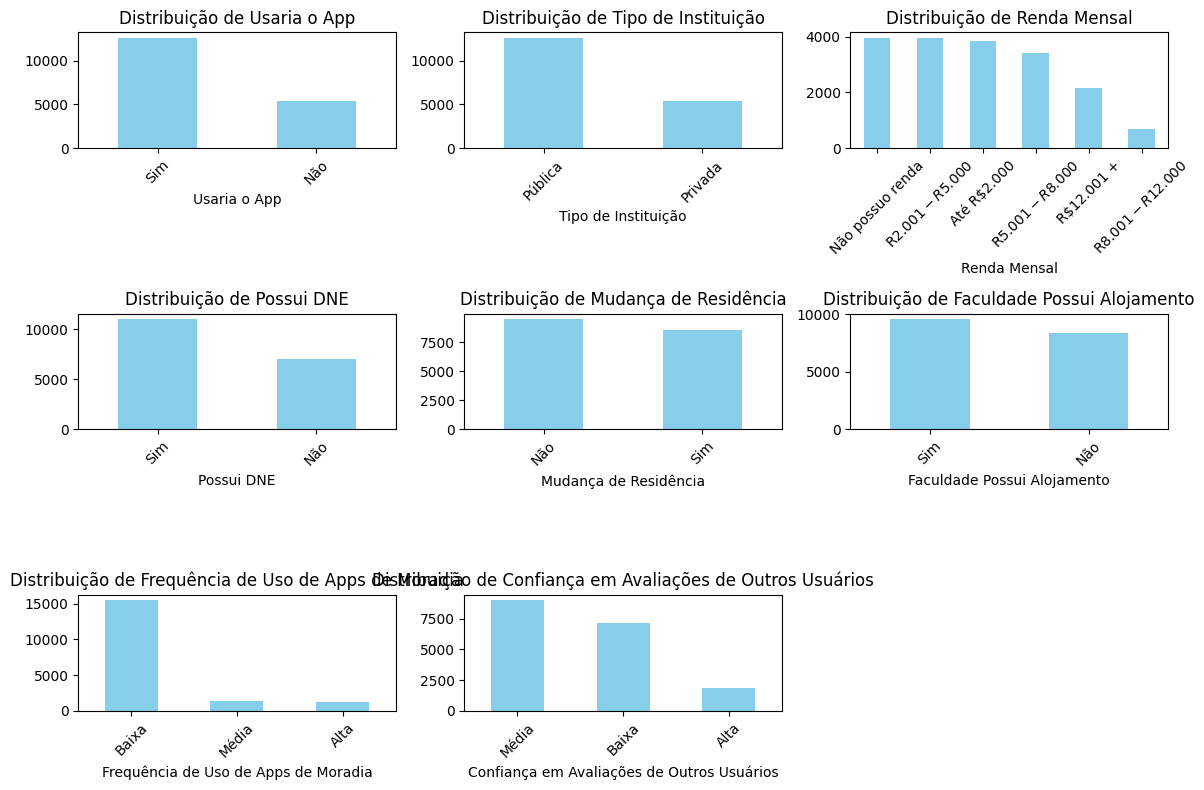

In [4]:
# Informações básicas do dataset
print(f'Dataset contém {dataset.shape[0]} linhas e {dataset.shape[1]} colunas')

# Estatísticas descritivas para variáveis numéricas
print('\nEstatísticas descritivas para variáveis numéricas (Idade):')
display(dataset.describe())

# Estatísticas descritivas para variáveis categóricas
print('\nEstatísticas descritivas para variáveis categóricas:')
display(dataset.describe(include='O'))

# Análise de frequências para variáveis categóricas
categorical_columns = dataset.select_dtypes(include=['object']).columns

# Visualização: Gráfico de barras para as variáveis categóricas mais importantes
plt.figure(figsize=(12, 8))

for i, column in enumerate(categorical_columns, 1):
    plt.subplot(3, 3, i)
    dataset[column].value_counts().plot(kind='bar', color='skyblue')
    plt.title(f'Distribuição de {column}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


#### O que podemos entender do dataset?
Com base nas visualizações acima, conseguimos identificar os seguintes pontos que podem nos ajudar a realizar o pré processamento:
- Alta quantidade de features;
- Poucas (apenas a idade) colunas quantitativas;
- Bastante variância nos dados de frequência de uso;

Para ter mais informações da base, vamos realizar um pré processamento básico, aplicando uma etapa de codificação das variàveis qualitativas e uma normalização da idade. 

# Pre-processamento

#### Separando atributos e respostas

In [5]:
x, y = dataset.drop(columns=['Usaria o App']), dataset['Usaria o App']

### Pré-processador
Criamos um pré-processador para poder realizar o Label encoding e normalização dos dados, podendo ser usado para transformar os futuros inputs também.

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', OrdinalEncoder(), make_column_selector(dtype_include=object)), # Codificação
        ('scaling', StandardScaler(), make_column_selector(dtype_include=np.number))   # Normalização
    ],
    remainder='passthrough', # Ignora a coluna caso haja erro na transformação
    verbose_feature_names_out=False # Não concatena o nome da etapa realizada ao nome da coluna (ex: 'categorical_Possui DNE')
)

Aplicamos duas etapas de transformação importantes nos dados: redução de dimensionalidade com PCA e balanceamento de classes com SMOTE.

PCA (Principal Component Analysis): reduz a dimensionalidade dos dados ao preservar 95% da variância. Essa técnica elimina redundâncias e facilita o processamento.
SMOTE (Synthetic Minority Over-sampling Technique): equilibra o número de exemplos nas classes minoritárias criando novos exemplos sintéticos, o que ajuda os modelos de classificação a não favorecerem a classe majoritária.

In [7]:
# Inicializa o PCA para reduzir a dimensionalidade, mantendo 95% da variância dos dados
pca = PCA(n_components=0.95)

# Inicializa o SMOTE para balancear as classes, criando exemplos sintéticos para a classe minoritária
smote = SMOTE()

In [8]:
# Aplica o pré-processador para codificar variáveis categóricas e normalizar as numéricas
X_transformed = preprocessor.fit_transform(x)

# Reduz a dimensionalidade do conjunto de dados transformado usando PCA
X_transformed = pca.fit_transform(X_transformed)

#### Separação treino e teste

In [9]:
RANDOM_SEED = 70 # Garantindo que os resultados serão reproduziveis.
TEST_SIZE = 0.3  # O tamanho dos dados de treino será de 30%.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

In [11]:
X_train.head()

,Tipo de Instituição,Idade,Renda Mensal,Possui DNE,Mudança de Residência,Faculdade Possui Alojamento,Frequência de Uso de Apps de Moradia,Confiança em Avaliações de Outros Usuários
7635,Pública,24,Até R$2.000,Sim,Sim,Sim,Alta,Baixa
9188,Pública,33,R$2.001 - R$5.000,Sim,Sim,Sim,Baixa,Média
2185,Privada,26,R$12.001 +,Sim,Não,Sim,Baixa,Alta
6275,Pública,43,Até R$2.000,Sim,Não,Sim,Baixa,Baixa
5098,Pública,27,Até R$2.000,Sim,Sim,Sim,Baixa,Baixa


In [12]:
X_train_transformed, X_test_transformed, y_train_transformed, y_test_transformed = train_test_split(X_transformed, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

In [13]:
# Evitando que o conjunto de teste seja contaminado com exemplos sintéticos
X_train_transformed, y_train_transformed = smote.fit_resample(X_train_transformed, y_train_transformed)

# Modelos

## Teste inicial

#### Procurando melhor DecisionTree

Estamos utilizando o GridSearchCV para realizar uma busca em grade (grid search) pelos melhores hiperparâmetros de um modelo de árvore de decisão (DecisionTreeClassifier). O GridSearchCV explora várias combinações de parâmetros especificados em dt_param_grid para identificar a configuração que maximiza a acurácia do modelo. Esse processo usa validação cruzada (com cv=5), o que ajuda a validar o desempenho dos hiperparâmetros sem sobreajustar o modelo ao conjunto de treino.



In [14]:
# Define o modelo de árvore de decisão básico, que será otimizado por GridSearch
dt_model = DecisionTreeClassifier()

# Define o grid de hiperparâmetros a serem testados durante a busca
# criterion: Função de medição de impureza dos nós (gini ou entropy)
# splitter: Estratégia de divisão dos nós (best para melhor divisão ou random para divisão aleatória)
# max_depth: Profundidade máxima da árvore, None para não limitar
# min_samples_split: Número mínimo de amostras para dividir um nó
# min_samples_leaf: Número mínimo de amostras para formar uma folha
# max_features: Número máximo de atributos a considerar para cada divisão (None, sqrt, ou log2)
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

# Configura o GridSearchCV para buscar a melhor combinação de hiperparâmetros para o modelo de árvore de decisão
# cv=5: Utiliza 5 divisões para validação cruzada
# scoring='accuracy': Usa acurácia como métrica de avaliação
# n_jobs=-1: Utiliza todos os núcleos disponíveis para processamento paralelo
dt_grid_search = GridSearchCV(estimator=dt_model, param_grid=dt_param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Realiza a busca em grade e ajusta o modelo com os dados de treino transformados e balanceados
dt_grid_search.fit(X_train_transformed, y_train_transformed)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20],
                         'splitter': ['best', 'random']},
             scoring='accuracy')

#### Procurando melhor K para o KNN

realizamos uma busca em grade (GridSearchCV) para encontrar o valor ideal de k no algoritmo K-Nearest Neighbors (KNN), visando maximizar a acurácia. A busca considera diferentes configurações para o número de vizinhos (n_neighbors), pesos das amostras (weights), e a norma de distância (p). Esse processo usa validação cruzada com cinco divisões (cv=5), o que reduz a possibilidade de sobreajuste e ajuda a generalizar o desempenho do modelo.

In [15]:
# Define o modelo K-Nearest Neighbors, que será ajustado pelo GridSearch
knn_model = KNeighborsClassifier()

# Define o grid de hiperparâmetros para o KNN
# n_neighbors: número de vizinhos considerados para determinar a classe
# weights: método de ponderação das amostras (uniform para peso igual ou distance para peso baseado na distância)
# p: tipo de distância usada (1 para Manhattan, 2 para Euclidiana)
knn_param_grid = {
    'n_neighbors': list(range(1, 100)),  # Testa valores de k de 1 a 99
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# Configura o GridSearchCV para o modelo KNN com validação cruzada de 5 divisões
# scoring='accuracy': usa acurácia como métrica de avaliação
# n_jobs=-1: permite processamento paralelo, usando todos os núcleos disponíveis
knn_grid_search = GridSearchCV(knn_model, knn_param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Executa a busca e ajusta o modelo KNN com os dados de treino transformados e balanceados
knn_grid_search.fit(X_train_transformed, y_train_transformed)

# Obtém o melhor valor para o parâmetro k e a melhor acurácia obtida com essa configuração
best_k = knn_grid_search.best_params_['n_neighbors']
best_accuracy = knn_grid_search.best_score_

# Exibe os resultados da busca em grade
print(f"Melhor valor de k: {best_k}")
print(f"Melhor acurácia obtida com o melhor k: {best_accuracy}")

Melhor valor de k: 81
Melhor acurácia obtida com o melhor k: 0.7807856952535033


In [16]:
len(knn_grid_search.cv_results_['mean_test_score'])

396

#### Definindo modelos

In [17]:
# Obtém o melhor estimador para cada modelo após a busca em grade
knn = knn_grid_search.best_estimator_
decision_tree = dt_grid_search.best_estimator_
naive_bayes = GaussianNB()  # Modelo Naive Bayes com configuração padrão

#### Treinando modelo
Treina cada modelo com os dados de treino transformados e balanceados


In [18]:
knn.fit(X_train_transformed, y_train_transformed)
decision_tree.fit(X_train_transformed, y_train_transformed)
naive_bayes.fit(X_train_transformed, y_train_transformed)

GaussianNB()

#### Prevendo dados de teste
Realiza previsões no conjunto de teste para cada modelo

In [19]:
knn_predict = knn.predict(X_test_transformed)
decision_tree_predict = decision_tree.predict(X_test_transformed)
naive_bayes_predict = naive_bayes.predict(X_test_transformed)


Função auxiliar para formatar o classification_report como DataFrame

In [20]:
def display_classification_report(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, output_dict=True)  # Gera o relatório em formato de dicionário
    df_report = pd.DataFrame(report).transpose()  # Converte para DataFrame e transposta para facilitar a leitura
    print(f"\nClassification Report for {model_name}:\n")
    display(df_report)

#### Métricas inciais
Exibe as métricas de classificação para cada modelo

In [21]:
display_classification_report(y_test, knn_predict, "K-Nearest Neighbors")
display_classification_report(y_test, decision_tree_predict, "Decision Tree")
display_classification_report(y_test, naive_bayes_predict, "Naive Bayes")


Classification Report for K-Nearest Neighbors:



,precision,recall,f1-score,support
Não,0.546457,0.626731,0.583847,1661.000000
Sim,0.822604,0.768922,0.794858,3739.000000
accuracy,0.725185,0.725185,0.725185,0.725185
macro avg,0.684530,0.697827,0.689353,5400.000000
weighted avg,0.737663,0.725185,0.729952,5400.000000



Classification Report for Decision Tree:



,precision,recall,f1-score,support
Não,0.541732,0.621312,0.578800,1661.000000
Sim,0.820029,0.766515,0.792369,3739.000000
accuracy,0.721852,0.721852,0.721852,0.721852
macro avg,0.680880,0.693914,0.685585,5400.000000
weighted avg,0.734427,0.721852,0.726677,5400.000000



Classification Report for Naive Bayes:



,precision,recall,f1-score,support
Não,0.422698,0.748946,0.540400,1661.000000
Sim,0.830281,0.545600,0.658489,3739.000000
accuracy,0.608148,0.608148,0.608148,0.608148
macro avg,0.626489,0.647273,0.599445,5400.000000
weighted avg,0.704911,0.608148,0.622166,5400.000000


### Avaliação do Overfitting
Utilizamos os dados de treino para prever os rótulos e avaliar a performance dos modelos. Comparando as métricas obtidas nos dados de treino com aquelas nos dados de teste, podemos identificar indícios de overfitting. Overfitting ocorre quando um modelo aprende excessivamente os detalhes e o ruído nos dados de treino, resultando em um desempenho inferior em dados não vistos (teste). Analisamos as métricas de precisão, recall e F1-score para cada modelo, a fim de verificar se há uma discrepância significativa entre o desempenho nos conjuntos de treino e teste.


In [22]:
# Realiza previsões utilizando os dados de treino para avaliar o desempenho do modelo
knn_predict_train = knn.predict(X_train_transformed)  # Previsões para KNN
decision_tree_predict_train = decision_tree.predict(X_train_transformed)  # Previsões para Decision Tree
naive_bayes_predict_train = naive_bayes.predict(X_train_transformed)  # Previsões para Naive Bayes

In [23]:
display_classification_report(y_train_transformed, knn_predict_train, "K-Nearest Neighbors")
display_classification_report(y_train_transformed, decision_tree_predict_train, "Decision Tree")
display_classification_report(y_train_transformed, naive_bayes_predict_train, "Naive Bayes")


Classification Report for K-Nearest Neighbors:



,precision,recall,f1-score,support
Não,0.853053,0.915499,0.883173,8852.000000
Sim,0.908825,0.842296,0.874296,8852.000000
accuracy,0.878897,0.878897,0.878897,0.878897
macro avg,0.880939,0.878897,0.878735,17704.000000
weighted avg,0.880939,0.878897,0.878735,17704.000000



Classification Report for Decision Tree:



,precision,recall,f1-score,support
Não,0.853053,0.915499,0.883173,8852.000000
Sim,0.908825,0.842296,0.874296,8852.000000
accuracy,0.878897,0.878897,0.878897,0.878897
macro avg,0.880939,0.878897,0.878735,17704.000000
weighted avg,0.880939,0.878897,0.878735,17704.000000



Classification Report for Naive Bayes:



,precision,recall,f1-score,support
Não,0.610142,0.727180,0.663540,8852.00000
Sim,0.662427,0.535359,0.592153,8852.00000
accuracy,0.631270,0.631270,0.631270,0.63127
macro avg,0.636284,0.631270,0.627846,17704.00000
weighted avg,0.636284,0.631270,0.627846,17704.00000


## Cross-Validation

### Avaliação de Modelos com Validação Cruzada

Nesta seção, realizaremos a validação cruzada para os modelos K-Nearest Neighbors (KNN), Decision Tree e Naive Bayes. A validação cruzada é uma técnica importante em machine learning que permite avaliar a capacidade de generalização de um modelo ao dividir os dados em múltiplas partes. Cada parte é utilizada como um conjunto de teste enquanto as demais são utilizadas para treinar o modelo.

Para cada modelo, utilizaremos a validação cruzada com 5 dobras (folds). Isso significa que os dados de treinamento serão divididos em cinco subconjuntos, e o modelo será treinado e avaliado cinco vezes, cada vez utilizando um subconjunto diferente como conjunto de teste e o restante como conjunto de treinamento. 

As principais vantagens da validação cruzada incluem:

1. **Redução de Variância**: A validação cruzada ajuda a mitigar a variabilidade das estimativas de desempenho que podem ocorrer quando se utiliza apenas um único conjunto de teste.
2. **Avaliação mais Robusta**: A média das métricas de desempenho obtidas em várias execuções oferece uma avaliação mais robusta da performance do modelo em dados não vistos.
3. **Ajuste de Hiperparâmetros**: Facilita a seleção de hiperparâmetros ao permitir que os modelos sejam avaliados de forma mais abrangente.

Após a execução da validação cruzada, apresentaremos as métricas de acurácia médias para cada modelo, permitindo uma comparação direta de seu desempenho.


#### KNN

In [24]:
# Criação de um pipeline que inclui o pré-processamento, PCA e o modelo KNN otimizado
pipeline_knn = ImbPipeline(steps=[
    ('preprocessor', preprocessor),  # Passo para pré-processamento dos dados
    ('pca', pca),  # Passo para redução de dimensionalidade usando PCA
    ('model', knn_grid_search.best_estimator_)  # Passo para o modelo KNN otimizado
])

# Avalia o modelo KNN utilizando validação cruzada com 5 dobras
knn_cv_scores = cross_val_score(pipeline_knn, X_train, y_train, cv=5, scoring='accuracy')

# Calcula a acurácia média a partir das pontuações obtidas na validação cruzada
knn_mean_acurracy = round(knn_cv_scores.mean() * 100, 4)


#### Decision Tree

In [25]:
# Criação do pipeline para o modelo de Decision Tree
pipeline_decision_tree = ImbPipeline(steps=[
    ('preprocessor', preprocessor),  # Passo para o pré-processamento dos dados
    ('pca', pca),                    # Passo para a redução de dimensionalidade usando PCA
    ('model', dt_grid_search.best_estimator_)  # O melhor modelo obtido da busca em grade
])

# Avaliação do modelo utilizando validação cruzada
dt_cv_scores = cross_val_score(pipeline_decision_tree, X_train, y_train, cv=5, scoring='accuracy')
# Cálculo da acurácia média a partir das pontuações de validação cruzada
dt_mean_acurracy = round(dt_cv_scores.mean() * 100, 4)  # Formatação da acurácia média

#### Naive Bayes

In [26]:
# Criação do pipeline para o modelo Naive Bayes
pipeline_naive_bayes = ImbPipeline(steps=[
    ('preprocessor', preprocessor),  # Passo para o pré-processamento dos dados
    ('pca', pca),                    # Passo para a redução de dimensionalidade usando PCA
    ('model', GaussianNB())          # Modelo Naive Bayes
])

# Avaliação do modelo utilizando validação cruzada
nb_cv_scores = cross_val_score(pipeline_naive_bayes, X_train, y_train, cv=5, scoring='accuracy')
# Cálculo da acurácia média a partir das pontuações de validação cruzada
nb_mean_acurracy = round(nb_cv_scores.mean() * 100, 4)  # Formatação da acurácia média

Impressão da média de acurácia obtida por validação cruzada para cada modelo

In [27]:
print(f"Média Acurácia Cross-Validation:\n\n"
      f"KNN: {knn_mean_acurracy}%\n"             # Acurácia média do modelo KNN
      f"Decision Tree: {dt_mean_acurracy}%\n"    # Acurácia média do modelo Decision Tree
      f"Naive Bayes: {nb_mean_acurracy}%\n")      # Acurácia média do modelo Naive Bayes

Média Acurácia Cross-Validation:

KNN: 75.3413%
Decision Tree: 73.0317%
Naive Bayes: 70.7698%



### Serialização do modelo

In [28]:
# Seleção do pipeline KNN como o pipeline a ser salvo
pipeline = pipeline_knn

In [29]:
# Salvando o modelo KNN treinado em um arquivo chamado 'model.pkl'
dump(pipeline, f'model.pkl')

['model.pkl']

# Relatório final do modelo

### Matriz de confusão

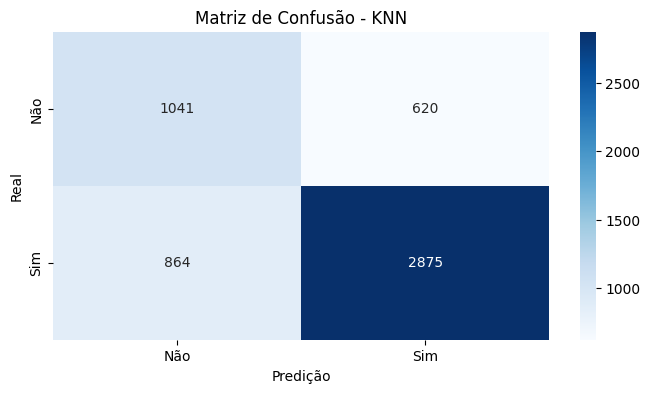

In [30]:
# Calcular a matriz de confusão
cm = confusion_matrix(y_test, knn_predict)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Não', 'Sim'], yticklabels=['Não', 'Sim'])
plt.title('Matriz de Confusão - KNN')
plt.xlabel('Predição')
plt.ylabel('Real')
plt.show()

### Curva ROC

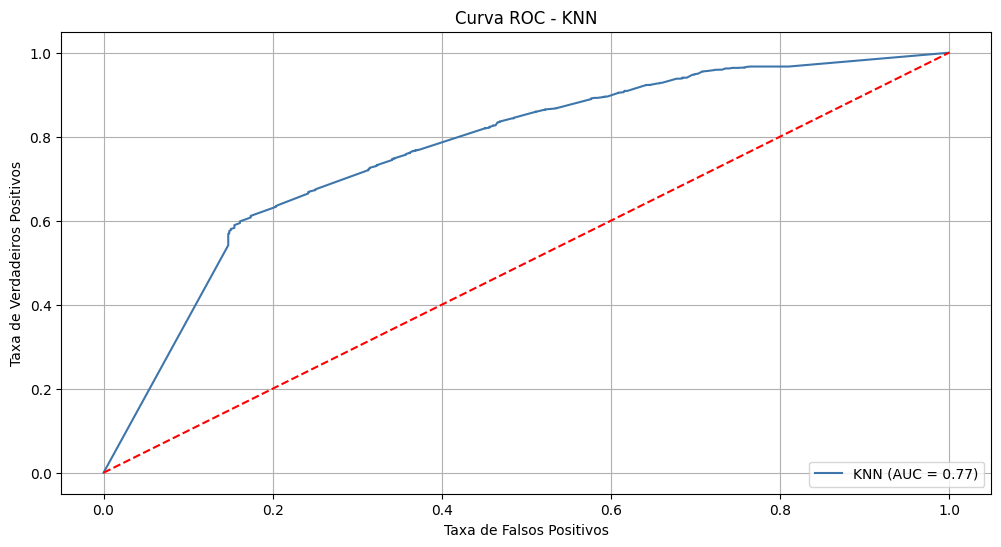

In [31]:
# Codificar rótulos
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

# Calcular as probabilidades de previsão
y_prob = knn.predict_proba(X_test_transformed)[:, 1]

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test_encoded, y_prob)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr, color='#3e76ab', label=f'KNN (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Curva ROC - KNN')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### Acirácia em Função de K

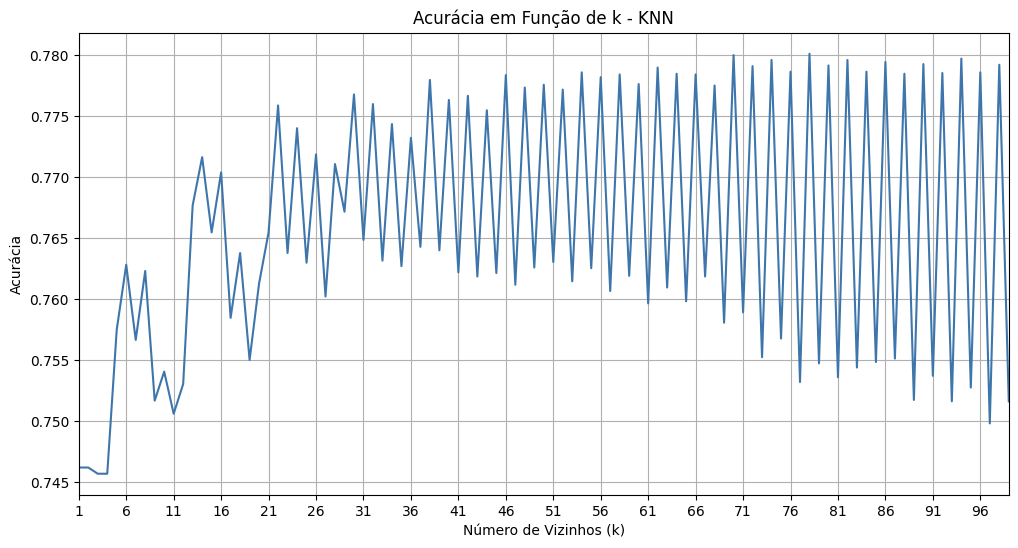

In [32]:
k_values = knn_param_grid['n_neighbors']
accuracies = knn_grid_search.cv_results_['mean_test_score'][:len(k_values)]

plt.figure(figsize=(12,6 ))
plt.plot(k_values, accuracies, color='#3e76ab')
plt.title('Acurácia em Função de k - KNN')
plt.xlabel('Número de Vizinhos (k)')
plt.ylabel('Acurácia')
plt.xlim(1, 99)
plt.xticks(range(1, 100, 5))
plt.grid()
plt.show()


### Calcular as distâncias dos vizinhos

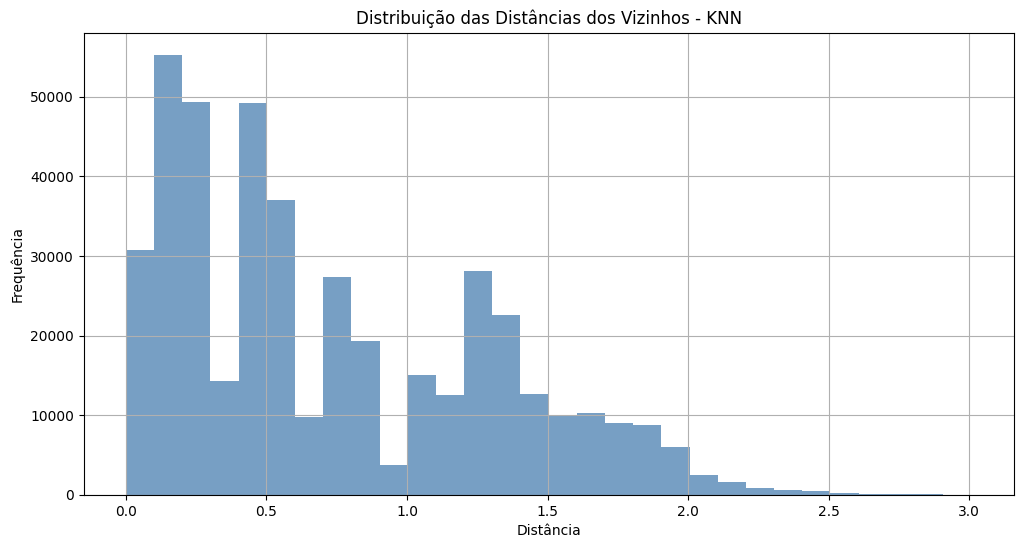

In [33]:
distances, indices = knn.kneighbors(X_test_transformed)

plt.figure(figsize=(12, 6))
plt.hist(distances.flatten(), bins=30, color='#3e76ab', alpha=0.7)
plt.title('Distribuição das Distâncias dos Vizinhos - KNN')
plt.xlabel('Distância')
plt.ylabel('Frequência')
plt.grid()
plt.show()

### Precisão e o recall em diferentes limiares de decisão

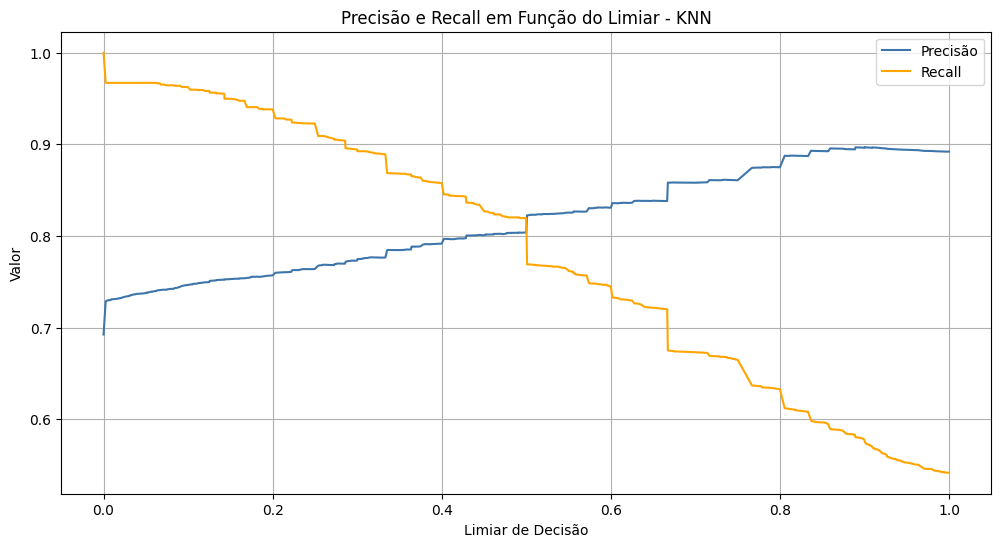

In [34]:
# Transformar rótulos categóricos em numéricos
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)  # Converte 'Sim'/'Não' para 1/0
y_prob = knn.predict_proba(X_test_transformed)[:, 1]  # Probabilidades de previsão para a classe positiva

# Calcular precisão e recall
precision, recall, thresholds = precision_recall_curve(y_test_encoded, y_prob)

# Plotar precisão e recall
plt.figure(figsize=(12, 6))
plt.plot(thresholds, precision[:-1], label='Precisão', color='#3e76ab')
plt.plot(thresholds, recall[:-1], label='Recall', color='orange')
plt.title('Precisão e Recall em Função do Limiar - KNN')
plt.xlabel('Limiar de Decisão')
plt.ylabel('Valor')
plt.legend()
plt.grid()
plt.show()


## Matemática 3: Justificativa de escolha do modelo KNN

#### Justificativas para Escolher o KNN

1.  **Redução de Ruído com Alto Valor de k**:
    
    -   Um valor mais alto de k=81 ajuda a reduzir o impacto de ruídos e outliers, pois considera uma média de 72 vizinhos para cada previsão, suavizando as flutuações locais. Isso é relevante considerando a presença de variáveis categóricas e contínuas que podem gerar alguma dispersão nos dados.
2.  **Bom Desempenho em Métricas de Classificação**:
    
    -   O KNN obteve uma acurácia média de 75,34% na validação cruzada e resultados consistentes de precisão, recall e f1-score nas classes de interesse. Em particular, o modelo teve um desempenho robusto na classe "Sim", que é a categoria de maior interesse para identificar potenciais clientes.
    -   A métrica de f1-score reflete o bom equilíbrio entre precisão e recall, garantindo que o modelo seja capaz de identificar adequadamente clientes potenciais sem perder precisão.
3.  **Capacidade de Generalização e Robustez a Overfitting**:
    
    -   O KNN apresentou **resultados similares nos conjuntos de treino e teste**, o que sugere **médio overfitting**, com uma diferença de 13% de acurácia. A utilização de validação cruzada e o uso do valor de k adequado contribuíram para um comportamento consistente e previsível do modelo, mesmo em dados não vistos.
4.  **Interpretação e Transparência**:
    
    -   A natureza baseada em instâncias do KNN oferece uma transparência interpretativa: podemos explicar cada predição com base na proximidade aos k vizinhos mais próximos, o que facilita a comunicação dos resultados de forma intuitiva.
5. **Tempo de processamento**

    -  Uma das preocupações em usar o KNN é que ele não gera um modelo, mas apenas "trava" os dados de treinamento e calcula a distância do novo dado em relação a todos os outros. Isso implica em normalmente, caso o conjunto de treino seja grande, uma grande espera para conseguir a classificação.
    No nosso caso, a requisição feita para a [API](https://flask-predict-proba.onrender.com/apidocs/) que consome do KNN está tendo sua resposta em menos de 2s. 
6. **Verificação das métricas**

    -  Verificamos principalmente a diferença das acurácias entre as classes, e não apresentou uma diferença significativa o suficiente para indicar que o modelo está apenas "chutando" em uma classe e realmente acertando na outra, gerando assim um vies. As métricas de F1-Score também acompanham os resultados esperados para cada classe. Foi utilizado o SMOTE para diminuir esta diferença entre as classes.
### Conclusão

Em resumo, o KNN foi escolhido para este projeto devido a sua simplicidade, robustez e desempenho sólido nos dados fornecidos. Sua capacidade de ajustar o valor de k, faz com que ele se adapte bem a este cenário de múltiplas variáveis categóricas e contínuas, sendo capaz de capturar a variação nos dados sem suposições restritivas sobre distribuições.

Os fundamentos matemáticos, somados aos bons resultados nas métricas de classificação, tornam o KNN uma escolha justificada e eficaz para a análise de clientes potenciais no contexto do APP.